In [1]:
!pip uninstall --yes torchtext
!pip install torchtext==0.10.0


Found existing installation: torchtext 0.14.1
Uninstalling torchtext-0.14.1:
  Successfully uninstalled torchtext-0.14.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.


In [2]:
!pip install -q transformers
!pip install -q hazm
!pip install -q clean-text[gpl]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 112.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 KB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 KB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 28.7 MB/s eta 0:00:00


In [3]:
import time, random, math, string
import hazm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch
import torch.nn as nn
import torch.optim as optim
#from torchtext.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
from torchtext.legacy import data
from transformers import BertConfig, BertTokenizer

import torch.nn.functional as F

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [5]:
def readData(file_name):
  dataa = pd.read_csv(file_name, sep="\n")
  dataa.drop(0, axis=0, inplace=True)
  dataa.rename(columns={file_name: 'poem'}, inplace=True)
  return dataa

In [9]:
file_name="/content/ferdousi.txt"
dataa = readData(file_name)

In [6]:
file_name="/content/drive/MyDrive/Colab Notebooks/HW4/ferdousi.txt"
dataa = readData(file_name)

FileNotFoundError: ignored

In [10]:
inputt=dataa[0:-1:2]
outputt=dataa[1:-1:2]

In [11]:
inputt

,ferdousi.txt
1,به نام خداوند جان و خرد
3,خداوند نام و خداوند جای
5,خداوند کیوان و گردان سپهر
7,ز نام و نشان و گمان برترست
9,به بینندگان آفریننده را
...,...
99207,همش رای و هم دانش وهم نسب
99209,سرآمد کنون قصهٔ یزدگرد
99211,ز هجرت شده پنج هشتادبار
99213,چواین نامور نامه آمد ببن


In [12]:
outputt

,ferdousi.txt
2,کزین برتر اندیشه برنگذرد
4,خداوند روزی ده رهنمای
6,فروزنده ماه و ناهید و مهر
8,نگارندهٔ بر شده پیکرست
10,نبینی مرنجان دو بیننده را
...,...
99208,چراغ عجم آفتاب عرب
99210,به ماه سفندار مد روز ارد
99212,به نام جهانداور کردگار
99214,ز من روی کشور شود پرسخن


In [13]:
inputt['len'] = inputt['ferdousi.txt'].apply(lambda t: len(hazm.word_tokenize(t)))
outputt['len']= outputt['ferdousi.txt'].apply(lambda t: len(hazm.word_tokenize(t)))

<ipython-input-13-357d960cb52a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inputt['len'] = inputt['ferdousi.txt'].apply(lambda t: len(hazm.word_tokenize(t)))
<ipython-input-13-357d960cb52a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputt['len']= outputt['ferdousi.txt'].apply(lambda t: len(hazm.word_tokenize(t)))


In [14]:
inputt

,ferdousi.txt,len
1,به نام خداوند جان و خرد,6
3,خداوند نام و خداوند جای,5
5,خداوند کیوان و گردان سپهر,5
7,ز نام و نشان و گمان برترست,7
9,به بینندگان آفریننده را,4
...,...,...
99207,همش رای و هم دانش وهم نسب,7
99209,سرآمد کنون قصهٔ یزدگرد,4
99211,ز هجرت شده پنج هشتادبار,5
99213,چواین نامور نامه آمد ببن,5


In [15]:
outputt

,ferdousi.txt,len
2,کزین برتر اندیشه برنگذرد,4
4,خداوند روزی ده رهنمای,4
6,فروزنده ماه و ناهید و مهر,6
8,نگارندهٔ بر شده پیکرست,4
10,نبینی مرنجان دو بیننده را,5
...,...,...
99208,چراغ عجم آفتاب عرب,4
99210,به ماه سفندار مد روز ارد,6
99212,به نام جهانداور کردگار,4
99214,ز من روی کشور شود پرسخن,6


In [16]:
#inputt["ferdousi.txt"][3]
outputt["ferdousi.txt"][2]

'کزین برتر اندیشه برنگذرد'

In [17]:
train=[]
for i in range(len(inputt)):
  train.append((inputt["ferdousi.txt"][2*i+1],outputt["ferdousi.txt"][2*i+2]))

In [18]:
min_max_len = inputt['len'].min(), inputt['len'].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 2 	Max: 11


In [19]:
min_max_len = outputt['len'].min(), outputt['len'].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 2 	Max: 11


In [ ]:
###
# general config
MAX_LEN = 11
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-taaghceh/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [ ]:
#tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

In [ ]:
idx = np.random.randint(0, len(train))
sample_poem = train[idx]

In [ ]:
sample_poem

('دو اشتر بدی زیر تابوت شاه', 'چپ و راست پیش و پس اندر سپاه')

In [ ]:
##
tokensin = tokenizer.tokenize(sample_poem[0])
tokensout = tokenizer.tokenize(sample_poem[1])
token_idsin = tokenizer.convert_tokens_to_ids(tokensin)
token_idsout = tokenizer.convert_tokens_to_ids(tokensout)

In [ ]:
##
print(f'   Poem: {sample_poem}')
print(f'   Tokens: {tokensin}')
print(f'Token IDs: {token_idsin}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokensout)}')
print(f'Token IDs: {token_idsout}')

   Poem: ('دو اشتر بدی زیر تابوت شاه', 'چپ و راست پیش و پس اندر سپاه')
   Tokens: ['دو', 'اشتر', 'بدی', 'زیر', 'تابوت', 'شاه']
Token IDs: [2897, 26852, 7085, 3150, 18999, 3603]
   Tokens: چپ و راست پیش و پس اندر سپاه
Token IDs: [6149, 1379, 4272, 2958, 1379, 2965, 11840, 4943]


In [ ]:
##
tokenizer.convert_ids_to_tokens(token_idsin)

['دو', 'اشتر', 'بدی', 'زیر', 'تابوت', 'شاه']

In [ ]:
##
source = Field(tokenize= lambda x: tokenizer.tokenize(x) , init_token='<sos>', eos_token='<eos>',fix_length=15)
target = Field(tokenize= lambda x: tokenizer.tokenize(x) , init_token='<sos>', eos_token='<eos>',fix_length=15)

In [20]:
source = Field(tokenize= lambda x: x.split() , init_token='<sos>', eos_token='<eos>',fix_length=15)
target = Field(tokenize= lambda x: x.split() , init_token='<sos>', eos_token='<eos>',fix_length=15)

In [21]:
fields = {("label",target ),("text", source)}

In [22]:
for i in range(10):
  print(random.randint(0,5))

3
4
1
5
5
2
4
2
0
1


In [23]:
f = open('items.txt','w')
f1 = open('itemst.txt','w')
f2 = open('itemsv.txt','w')
f3 = open('itemstv.txt','w')
for example in train:
  tt=random.randint(0,6)
  if tt==6:
    f3.write(str(example[0]+","+example[1]))
    f3.write("\n")
  if tt==5:
    f2.write(str(example[0]+","+example[1]))
    f2.write("\n")
  if tt<5:
    f1.write(str(example[0]+","+example[1]))
    f1.write("\n")
  f.write(str(example[0]+","+example[1]))
  f.write("\n")
f.close()
f1.close()
f2.close()
f3.close()

In [24]:
 dataset = data.TabularDataset(
                path='items.txt', format="csv",
                skip_header=False, fields=fields,
                csv_reader_params={"quotechar": None})

In [25]:
 train_d,val_d,test_d = data.TabularDataset.splits(
                path='/content', format="csv",
                skip_header=False, fields=fields,
                train='itemst.txt', validation="itemsv.txt", test="itemstv.txt")

In [26]:
vars(val_d.examples[2])

{'label': ['کسی', 'کو', 'خرد', 'را', 'ندارد', 'ز', 'پیش'],
 'text': ['دلش', 'گردد', 'از', 'کردهٔ', 'خویش', 'ریش']}

In [27]:
!git clone "https://github.com/Text-Mining/Persian-Wikipedia-Corpus.git"

Cloning into 'Persian-Wikipedia-Corpus'...
remote: Enumerating objects: 47, done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (47/47), 758.15 MiB | 18.05 MiB/s, done.
Updating files: 100% (14/14), done.


In [28]:
!unzip "Persian-Wikipedia-Corpus/models/glove/vectors.zip"

Archive:  Persian-Wikipedia-Corpus/models/glove/vectors.zip
  inflating: vectors.txt             


In [29]:
f = open("/content/vectors.txt",'r')
embhelper=f.read().strip().split("\n")
f.close()

In [30]:
words=[]
vecs=[]
for item in embhelper:
  words.append(item.split()[0])
  vecs.append([float(val) for val in item.split()[1:]])
wordss=np.array(words)
vecss=np.array(vecs)

In [31]:
wordss[100:120]

array(['متر', 'کتاب', 'تهران', 'کند', 'اثر', 'انجام', 'کرده',
       'می\u200cکنند', 'گروه', 'آلمان', 'پیش', 'داشته', 'سه', 'کیلومتر',
       'انگلیسی', 'اول', 'شود', 'ثبت', 'جمهوری', 'روز'], dtype='<U33')

In [32]:
wordss=np.insert(wordss,0,"<sos>")
wordss=np.insert(wordss,1,"<eos>")
wordss=np.insert(wordss,2,"<pad>")
wordss=np.insert(wordss,3,"<unk>")

In [33]:
vecss=np.insert(vecss,0,np.ones(50)*0.5)
vecss=np.insert(vecss,1,-np.ones(50)*0.5)
vecss=np.insert(vecss,2,np.ones(50)*0.25)
vecss=np.insert(vecss,3,-np.ones(50)*0.25)


In [34]:
torch_vectors=torch.tensor(vecss,dtype=torch.float32).to(device)

In [35]:
s2v={}
s2i={}
for i in range(len(wordss)):
  s2i[wordss[i]]=i
  s2v[wordss[i]]=torch_vectors[i]


In [36]:
source.build_vocab(dataset, min_freq=2)
target.build_vocab(dataset, min_freq=2)

In [37]:
source.vocab.set_vectors(stoi=s2i,vectors=torch_vectors,dim=50)
target.vocab.set_vectors(stoi=s2i,vectors=torch_vectors,dim=50)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATHC_SIZE = 128
# We use a BucketIterator instead of the standard Iterator as it create batches in such a way that it minimizes the amount 
# of padding in both the source and target sentences.
train_iter, valid_iter, test_iter = BucketIterator.splits((train_d,val_d,test_d),
                                                          batch_size=BATHC_SIZE, device=device)

In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout,source):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(source.vocab.vectors, freeze=False)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        return hidden, cell

In [40]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,target):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.embedding = nn.Embedding.from_pretrained(target.vocab.vectors, freeze=False)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch_size, output_dim]
        return prediction, hidden, cell

In [123]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=1):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs
    def create_mesraa(self, src, teacher_forcing_ratio=1):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = src.shape[1]
        trg_len = 10
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = (torch.zeros((batch_size),dtype=torch.long)).to(self.device)
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = top1
            
        return outputs


In [84]:
# First initialize our model.
INPUT_DIM = len(source.vocab)
OUTPUT_DIM = len(target.vocab)
ENC_EMB_DIM = 50
DEC_EMB_DIM = 50
HID_DIM = 64
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT,source)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT,target)

model = Seq2Seq(encoder, decoder, device).to(device)

In [85]:
def init_weight(model):
  for name, param in model.named_parameters():
    nn.init.uniform_(param.data,-0.1,0.1)
model.apply(init_weight)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7435, 50)
    (rnn): LSTM(50, 64, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7089, 50)
    (rnn): LSTM(50, 64, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=64, out_features=7089, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [86]:
optimizer=optim.Adam(model.parameters())
TRG_PAD_IDX=target.vocab.stoi[target.pad_token]
criterion= nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [87]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch.text
        trg = batch.label
        
        optimizer.zero_grad()
        # trg = [sen_len, batch_size]
        # output = [trg_len, batch_size, output_dim]
        output = model(src, trg)
        output_dim = output.shape[-1]
        
        # transfrom our output : slice off the first column, and flatten the output into 2 dim.
        output = output[1:].view(-1, output_dim) 
        trg = trg[1:].view(-1)
        # trg = [(trg_len-1) * batch_size]
        # output = [(trg_len-1) * batch_size, output_dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [88]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            src = batch.text
            trg = batch.label
            
            output = model(src, trg, 0) # turn off teacher forcing.
            
            # trg = [sen_len, batch_size]
            # output = [sen_len, batch_size, output_dim]
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [89]:
def epoch_time(start_time, end_time):
    
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time  / 60)
    elapsed_secs = int(elapsed_time -  (elapsed_mins * 60))
    return  elapsed_mins, elapsed_secs

In [90]:
N_EPOCHS = 20
t_l=[]
v_l=[]
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, train_iter, criterion)
    t_l.append(train_loss)
    v_l.append(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Seq2SeqModel.pt')
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")

Epoch: 01 | Time 0m 19s
	Train Loss: 6.284 | Train PPL: 536.084
	Valid Loss: 5.828 | Valid PPL: 339.670
Epoch: 02 | Time 0m 19s
	Train Loss: 5.705 | Train PPL: 300.386
	Valid Loss: 6.318 | Valid PPL: 554.656
Epoch: 03 | Time 0m 19s
	Train Loss: 5.585 | Train PPL: 266.320
	Valid Loss: 6.551 | Valid PPL: 700.259
Epoch: 04 | Time 0m 19s
	Train Loss: 5.514 | Train PPL: 248.097
	Valid Loss: 6.101 | Valid PPL: 446.122
Epoch: 05 | Time 0m 19s
	Train Loss: 5.448 | Train PPL: 232.394
	Valid Loss: 6.304 | Valid PPL: 546.524
Epoch: 06 | Time 0m 19s
	Train Loss: 5.394 | Train PPL: 220.011
	Valid Loss: 6.188 | Valid PPL: 487.047
Epoch: 07 | Time 0m 19s
	Train Loss: 5.349 | Train PPL: 210.475
	Valid Loss: 6.435 | Valid PPL: 623.431
Epoch: 08 | Time 0m 19s
	Train Loss: 5.299 | Train PPL: 200.215
	Valid Loss: 6.332 | Valid PPL: 562.112
Epoch: 09 | Time 0m 19s
	Train Loss: 5.248 | Train PPL: 190.101
	Valid Loss: 6.205 | Valid PPL: 495.102
Epoch: 10 | Time 0m 21s
	Train Loss: 5.196 | Train PPL: 180.493


KeyboardInterrupt: ignored

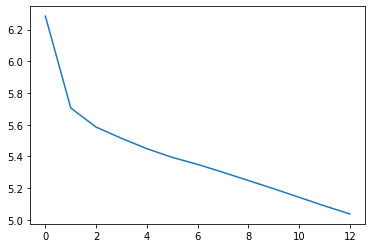

In [100]:
import matplotlib.pyplot as plt

ys = t_l
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()

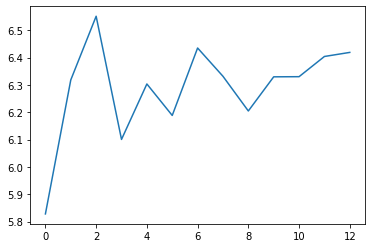

In [101]:
import matplotlib.pyplot as plt

ys = v_l
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()

In [91]:
for i, batch in enumerate(train_iter):
            
            src = batch.text

In [92]:
model_out=model.create_mesraa(src).argmax(2)

In [93]:
model_out

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 8,  8,  8,  ...,  8,  8,  8],
        [ 9, 84, 84,  ...,  9, 84, 84],
        ...,
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3],
        [ 3,  3,  3,  ...,  3,  3,  3]], device='cuda:0')

In [98]:
text=[target.vocab.itos[i] for i in model_out[:,50]]

In [99]:
text

['<unk>',
 'چو',
 'بشنید',
 'و',
 '<unk>',
 'و',
 'شهریار',
 '<eos>',
 '<eos>',
 '<eos>']

GRU:here we only need to chenge LSTM to GRU

In [ ]:
class Encoder1(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout,source):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding = nn.Embedding.from_pretrained(source.vocab.vectors, freeze=False)

        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)
        
        self.dropout = nn.Dropout(dropout)
    def forward(self, src):
        # src : [sen_len, batch_size]
        embedded = self.dropout(self.embedding(src))
        
        # embedded : [sen_len, batch_size, emb_dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [sen_len, batch_size, hid_dim * n_directions]
        # hidden = [n_layers * n_direction, batch_size, hid_dim]
        # cell = [n_layers * n_direction, batch_size, hid_dim]
        return hidden, cell

In [ ]:
class Decoder1(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout,target):
        super().__init__()
        
        self.output_dim = output_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        #self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.embedding = nn.Embedding.from_pretrained(target.vocab.vectors, freeze=False)
        
        self.rnn = nn.GRU(emb_dim, hid_dim, num_layers=self.n_layers, dropout=dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        # input = [batch_size]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        input = input.unsqueeze(0)
        # input : [1, ,batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        # output = [seq_len, batch_size, hid_dim * n_dir]
        # hidden = [n_layers * n_dir, batch_size, hid_dim]
        # cell = [n_layers * n_dir, batch_size, hid_dim]
        
        # seq_len and n_dir will always be 1 in the decoder
        prediction = self.fc_out(output.squeeze(0))
        # prediction = [batch_size, output_dim]
        return prediction, hidden, cell

In [102]:
class Seq2SeqGRU(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            'hidden dimensions of encoder and decoder must be equal.'
        assert encoder.n_layers == decoder.n_layers, \
            'n_layers of encoder and decoder must be equal.'
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = trg[0, :]
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = trg[t] if teacher_force else top1
            
        return outputs
    def create_mesraa(self, src, teacher_forcing_ratio=1):
        # src = [sen_len, batch_size]
        # trg = [sen_len, batch_size]
        # teacher_forcing_ratio : the probability to use the teacher forcing.
        batch_size = src.shape[1]
        trg_len = 10
        trg_vocab_size = self.decoder.output_dim
        
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        # first input to the decoder is the <sos> token.
        input = (torch.zeros((batch_size),dtype=torch.long)).to(self.device)
        for t in range(1, trg_len):
            # insert input token embedding, previous hidden and previous cell states 
            # receive output tensor (predictions) and new hidden and cell states.
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            # replace predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # decide if we are going to use teacher forcing or not.
            teacher_force = random.random() < teacher_forcing_ratio
            
            # get the highest predicted token from our predictions.
            top1 = output.argmax(1)
            # update input : use ground_truth when teacher_force 
            input = top1
            
        return outputs


In [119]:
# First initialize our model.
INPUT_DIM = len(source.vocab)
OUTPUT_DIM = len(target.vocab)
ENC_EMB_DIM = 50
DEC_EMB_DIM = 50
HID_DIM = 64
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

encoder = Encoder1(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT,source)
decoder = Decoder1(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT,target)

model1 = Seq2SeqGRU(encoder, decoder, device).to(device)

In [120]:
model1.apply(init_weight)

Seq2SeqGRU(
  (encoder): Encoder(
    (embedding): Embedding(7435, 50)
    (rnn): LSTM(50, 64, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7089, 50)
    (rnn): LSTM(50, 64, num_layers=2, dropout=0.2)
    (fc_out): Linear(in_features=64, out_features=7089, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [121]:
optimizer=optim.Adam(model1.parameters())
TRG_PAD_IDX=target.vocab.stoi[target.pad_token]
criterion= nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

In [122]:
N_EPOCHS = 10
t_l=[]
v_l=[]
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model1, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model1, train_iter, criterion)
    t_l.append(train_loss)
    v_l.append(valid_loss)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'Seq2SeqModel.pt')
    print(f"Epoch: {epoch+1:02} | Time {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}")

Epoch: 01 | Time 0m 20s
	Train Loss: 6.306 | Train PPL: 547.689
	Valid Loss: 5.859 | Valid PPL: 350.264
Epoch: 02 | Time 0m 18s
	Train Loss: 5.809 | Train PPL: 333.130
	Valid Loss: 5.765 | Valid PPL: 319.027
Epoch: 03 | Time 0m 20s
	Train Loss: 5.707 | Train PPL: 300.855
	Valid Loss: 5.719 | Valid PPL: 304.582
Epoch: 04 | Time 0m 19s
	Train Loss: 5.644 | Train PPL: 282.706
	Valid Loss: 5.687 | Valid PPL: 294.914
Epoch: 05 | Time 0m 19s
	Train Loss: 5.605 | Train PPL: 271.688
	Valid Loss: 5.666 | Valid PPL: 288.958
Epoch: 06 | Time 0m 19s
	Train Loss: 5.568 | Train PPL: 261.965
	Valid Loss: 5.659 | Valid PPL: 287.005
Epoch: 07 | Time 0m 19s
	Train Loss: 5.520 | Train PPL: 249.673
	Valid Loss: 5.639 | Valid PPL: 281.228
Epoch: 08 | Time 0m 19s
	Train Loss: 5.480 | Train PPL: 239.787
	Valid Loss: 5.629 | Valid PPL: 278.377
Epoch: 09 | Time 0m 20s
	Train Loss: 5.453 | Train PPL: 233.462
	Valid Loss: 5.607 | Valid PPL: 272.313
Epoch: 10 | Time 0m 19s
	Train Loss: 5.414 | Train PPL: 224.511


In [127]:
for i, batch in enumerate(train_iter):
            
            src = batch.text

In [128]:
model_out=model1.create_mesraa(src).argmax(2)

In [131]:
text=[target.vocab.itos[i] for i in model_out[:,5]]
print(text)

['<unk>', 'چو', 'از', '<unk>', 'و', '<eos>', '<eos>', '<eos>', '<eos>', '<eos>']


In [132]:
text

['<unk>',
 'چو',
 'از',
 '<unk>',
 'و',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>']

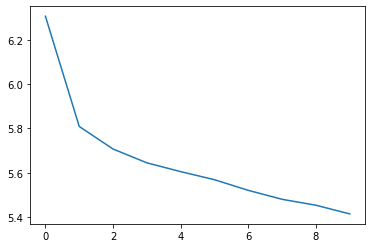

In [133]:
import matplotlib.pyplot as plt

ys = t_l
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()

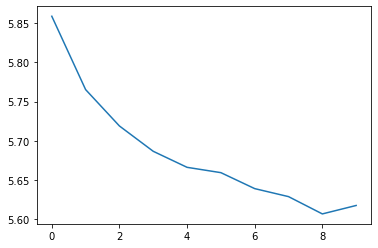

In [134]:
import matplotlib.pyplot as plt

ys = v_l
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.show()

gru works better!